In [2]:
import torch
import torchvision
from torchvision import datasets,transforms
from torch.autograd import Variable
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2
# 获取计算设备
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_path='../picture/cropped_panda.jpg'
orig=cv2.imread(image_path)[...,::-1]
orig=cv2.resize(orig,(224,224))
img=orig.copy().astype(np.float)
# 标准化
mean=[0.485,0.456,0.406]
std=[0.229,0.224,0.225]
img /= 255.0
img=(img-mean)/std
# WHC转化为CWH
img=img.transpose(2,0,1)
img= np.expand_dims(img,axis=0) #[3,224,224]->[1,3,224,224]
img=Variable(torch.from_numpy(img).to(device).float())

# 使用预测模型主要影响Dropout和BN层
model=models.alexnet(pretrained=True).to(device).eval()
label=np.argmax(model(img).data.cpu().numpy())
print('label={}'.format(label))

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /home/yanhuanqian/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:28<00:00, 8567658.04it/s] 


label=388


In [4]:
# 图像数据梯度可以获取
img.requires_grad=True
for param in model.parameters():
    param.requires_grad = False
    
optimizer=torch.optim.Adam([img])

# 定向攻击
target=288
target=Variable(torch.Tensor([float(target)]).to(device).long())
loss_func=torch.nn.CrossEntropyLoss()

# 训练
epochs=100
for epoch in range(epochs):
    # 梯度清零
    optimizer.zero_grad()
    output=model(img)
    loss=loss_func(output,target)
    label=np.argmax(output.data.cpu().numpy())
    print("epoch={} loss={} label={}".format(epoch,loss,label))
    # 定向攻击成功
    if label==target:
        break
    loss.backward()
    optimizer.step()

epoch=0 loss=12.659988403320312 label=388
epoch=1 loss=11.617825508117676 label=388
epoch=2 loss=10.7114896774292 label=388
epoch=3 loss=9.929174423217773 label=388
epoch=4 loss=9.274925231933594 label=388
epoch=5 loss=8.724658012390137 label=388
epoch=6 loss=8.258734703063965 label=388
epoch=7 loss=7.857272624969482 label=388
epoch=8 loss=7.491140842437744 label=388
epoch=9 loss=7.16511344909668 label=388
epoch=10 loss=6.861202239990234 label=388
epoch=11 loss=6.56635856628418 label=388
epoch=12 loss=6.272882461547852 label=388
epoch=13 loss=5.979673385620117 label=388
epoch=14 loss=5.695484161376953 label=388
epoch=15 loss=5.3949408531188965 label=388
epoch=16 loss=5.086625099182129 label=388
epoch=17 loss=4.783305644989014 label=388
epoch=18 loss=4.468852996826172 label=388
epoch=19 loss=4.162304878234863 label=388
epoch=20 loss=3.8563504219055176 label=388
epoch=21 loss=3.558104991912842 label=388
epoch=22 loss=3.2638802528381348 label=388
epoch=23 loss=2.973641872406006 label=293


In [16]:
# 对比展示原始图片和对抗样本图片
def show_images_diff(original_img,original_label,adversarial_img,adversarial_label):
    import matplotlib.pyplot as plt
    plt.figure()
    #归一化
    if original_img.any()>1.0:
        original_img=original_img/255.0
    if adversarial_img.any()>1.0:
        adversarial_img=adversarial_img/255.0
    plt.subplot(131)
    plt.title('original')
    plt.imshow(original_img)
    plt.axis('off')
    
    plt.subplot(132)
    plt.title('Adversarial')
    plt.imshow(adversarial_img)
    plt.axis('off')
    
    plt.subplot(133)
    plt.title('adversarial-orignial')
    difference= adversarial_img-original_img
    #(-1,1)->(0,1)
    difference=difference/abs(difference).max()/2.0 +0.5
    plt.imshow(difference,cmap=plt.cm.gray)
    plt.axis('off')
    plt.tight_layout()  #自动调整子图参数，使之填充整个图像区域
    plt.show()

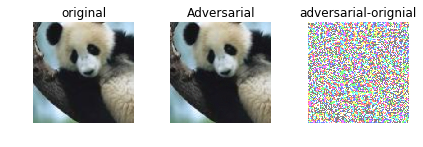

In [17]:
adv=img.data.cpu().numpy()[0]
#[3,224,224]->[224,224,3]
adv=adv.transpose(1,2,0)
# 还原像素范围并取整
adv=(adv*std)+mean
adv=adv*255.0
adv=np.clip(adv,0,255).astype(np.uint8)
show_images_diff(orig,338,adv,target.data.cpu().numpy()[0])